In [44]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
import numpy
from torch import nn
import numpy as np

In [45]:
#### Khởi tạo thông số
class GRUScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma = 0.01):
        super().__init__()
        self.save_hyperparameters()
        # Shape: (num_inputs, num_hiddens), .., (1x num_hiddens)
        shape1 = (num_inputs, num_hiddens)
        shape2 = (num_hiddens, num_hiddens)
        shape3 = (1, num_hiddens)
        # Update gate
        self.W_xz, self.W_hz, self.b_z = nn.Parameter(torch.randn(*shape1) * sigma), nn.Parameter(torch.randn(*shape2) * sigma), nn.Parameter(torch.randn(*shape3) * sigma)

        # Reset gate
        self.W_xr, self.W_hr, self.b_r = nn.Parameter(torch.randn(*shape1) * sigma), nn.Parameter(torch.randn(*shape2) * sigma), nn.Parameter(torch.randn(*shape3) * sigma)

        # Candidate hidden state
        self.W_xh, self.W_hh, self.b_h = nn.Parameter(torch.randn(*shape1) * sigma), nn.Parameter(torch.randn(*shape2) * sigma), nn.Parameter(torch.randn(*shape3) * sigma)

    def forward(self, inputs, H = None):
        if H is None:
            H = torch.zeros(size = (inputs.shape[1], self.num_hiddens), 
                            device = inputs.device)
        
        outputs = []

        for X in inputs:
            Z = torch.sigmoid(torch.matmul(X, self.W_xz) + 
                              torch.matmul(H, self.W_hz) + self.b_z)
            R = torch.sigmoid(torch.matmul(X, self.W_xr) + 
                              torch.matmul(H, self.W_hr) + self.b_r)

            H_hat = torch.tanh(torch.matmul(X, self.W_xh) + 
                               torch.matmul((R * H), self.W_hh) + self.b_h)
            H = Z * H + (1 - Z) * H_hat
            outputs.append(H)
        return outputs, H # Shape of outputs: (num_steps, batch_size, num_hiddens)

In [ ]:
class RNNLM(nn.Module, d2l.HyperParameters):
    def __init__(self, rnn, num_inputs, num_hiddens, lr = 2):
        super().__init__()
        self.save_hyperparameters()
        self.init_parameters()
        self.vocab_size = num_inputs

    def init_parameters(self):
        self.fc = nn.Linear(self.num_hiddens, self.num_inputs)
    
    def loss(self, y_hat, y):
        # Chuyển về ma trận với hàng là tất cả các từ trong batch và cột là xác suất xuất hiện của từ
        y_hat = y_hat.reshape(-1, y_hat.shape[-1])
        # Chuyển về vecto để lấy chỉ số khi nhân với logy_hat khi tính cross_entropy
        y = y.reshape(-1,)
        # print(y_hat.shape[0], len(y))
        assert y_hat.shape[0] == len(y) 
        return F.cross_entropy(y_hat, y, reduction='mean')

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        return l
    
    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        return l
    
    def one_hot(self, x):
        # print(self.vocab_size)
        return F.one_hot(x.T, self.vocab_size).type(torch.float32)
    
    def output_layer(self, inputs):
        outputs = [self.fc(x) for x in inputs]
        return torch.stack(outputs, 1) # Shape: (batch_size, num_steps, vocab_size)

    # Shape of inputs: (batch_size, num_steps, vocab_size)
    def forward(self, inputs, state = None):
        x = self.one_hot(inputs) # Shape: (num_steps, batch_size, vocab_size)
        outputs, _ = self.rnn(x, state)

        outputs = self.output_layer(outputs)
        return outputs

    def predict(self, prefix, num_preds, vocab, device=None):
        state, outputs = None, [vocab[prefix[0]]]
        for i in range(len(prefix) + num_preds - 1):
            X = torch.tensor([[outputs[-1]]], device=device)
            embs = self.one_hot(X)
            rnn_outputs, state = self.rnn(embs, state)
            if i < len(prefix) - 1:  # Warm-up period
                outputs.append(vocab[prefix[i + 1]])
            else:  # Predict num_preds steps
                Y = self.output_layer(rnn_outputs)
                outputs.append(int(Y.argmax(axis=2).reshape(1)))
        return ''.join([vocab.idx_to_token[i] for i in outputs])

In [47]:
data = d2l.TimeMachine(batch_size = 1024, num_steps=32)
gru = GRUScratch(num_inputs = len(data.vocab), num_hiddens = 64)

model2 = RNNLM(gru, len(data.vocab), num_hiddens=64)
model2

RNNLM(
  (rnn): GRUScratch()
  (fc): Linear(in_features=64, out_features=28, bias=True)
)

In [48]:
inputs = torch.ones(size = (1024, 32)).type(torch.int64)
model2(inputs).shape # (batch_size, num_steps, vocab_size)

torch.Size([1024, 32, 28])

In [49]:
model2.predict("abcdef", 12, data.vocab, "cpu")

'abcdefjjjjjjjjjjjj'

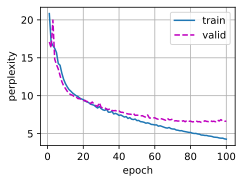

In [50]:
# trainer = d2l.Trainer(max_epochs=500, gradient_clip_val=1, num_gpus=1)
# trainer.fit(model, data)
train_iter = data.get_dataloader(True)
val_iter = data.get_dataloader(False)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
def prepare_batch(batch):
    if DEVICE == "cuda":
        batch = [x.to(DEVICE) for x in batch]
    return batch

def train(model : RNNLM, data, max_epochs = 100):
    model.to(DEVICE)
    optim = torch.optim.SGD(model.parameters(), model.lr)
    animator = d2l.Animator(
        xlabel = "epoch", ylabel = "perplexity", legend = ["train", "valid"]
    )
    for epoch in range(max_epochs):
        model.train()
        train_ppl = []
        valid_ppl = []
        for batch in train_iter:
            loss = model.training_step(prepare_batch(batch))
            optim.zero_grad()
            loss.backward()
            d2l.grad_clipping(model, 1)
            optim.step()
            train_ppl.append(np.exp(loss.cpu().detach().numpy()))
        
        for batch in val_iter:
            with torch.no_grad():
                loss = model.validation_step(prepare_batch(batch))
                valid_ppl.append(np.exp(loss.cpu().detach().numpy()))
        animator.add([epoch + 1] * 2, [np.mean(train_ppl), np.mean(valid_ppl)])

train(model2, data)

In [51]:
list(model2.parameters())

[Parameter containing:
 tensor([[-0.1718, -0.1808,  0.1602,  ...,  0.1045, -0.1804,  0.2305],
         [ 0.0092, -0.0047,  0.0135,  ..., -0.0011, -0.0165,  0.0128],
         [ 0.0445, -0.1941, -0.0936,  ...,  0.0975, -0.0387, -0.0146],
         ...,
         [ 0.0135,  0.0064, -0.0207,  ..., -0.0016, -0.0074,  0.0098],
         [-0.1041,  0.0108, -0.1584,  ..., -0.0320, -0.0138, -0.0369],
         [ 0.0024,  0.0186,  0.0302,  ...,  0.0051,  0.0011, -0.0084]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[ 0.1246, -0.0607, -0.2440,  ...,  0.0677,  0.0396, -0.0322],
         [-0.0794,  0.0307, -0.0908,  ...,  0.0888,  0.0054, -0.1003],
         [ 0.1509,  0.0101, -0.0783,  ...,  0.0289,  0.0256,  0.0320],
         ...,
         [-0.1793,  0.0321,  0.1620,  ..., -0.0970, -0.0306, -0.0180],
         [-0.0559,  0.2603,  0.2126,  ...,  0.1765, -0.0466,  0.0216],
         [ 0.0283,  0.1759,  0.1487,  ...,  0.0159,  0.0130,  0.0633]],
        device='cuda:0', r

In [52]:
model2.predict("time has come ", num_preds = 32, vocab = data.vocab, device = "cuda")

'time has come the precedter at a cour and the '